In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import pickle
from modules.functions import pymatgen_comp, data_generator_vec, check_cuda
from modules.pytorch_models import conditional_VAE, Generator, Discriminator
from modules.trained_models import get_uts_without_grain
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.neighbors import KernelDensity
import torch.nn as nn
import tqdm
import seaborn as sns
import umap
import json

2023-01-20 01:29:47.319525: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/scaler_y_multi.pkl','rb') as fid:
    scaler = pickle.load(fid)

# VAE

In [4]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'])
vec_comps = comp_dset.real_data
y = to_train_df['uts1200C'].values.reshape(-1,1).astype('float32')
y_scaled = uts_scaler.transform(y)

In [5]:
input_dim = vec_comps.shape[1]
batch_size = 1024
num_epochs = 100
learning_rate = 0.0001
latent_size = 4
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
vae = conditional_VAE(input_dim,1,latent_size).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [6]:
Xy = [[vec_comps[i], y_scaled[i]] for i in range(vec_comps.shape[0])]
dataloader = torch.utils.data.DataLoader(
    Xy, batch_size=batch_size,
    shuffle=True, 
    pin_memory=torch.cuda.is_available())
for epoch in range(num_epochs):
    overall_loss = 0
    for batch_idx,data in enumerate(dataloader):
        inputs, cond = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            cond = cond.cuda()
        optimizer.zero_grad()
        decoded, sigmoid, input_vae, mu, sigma = vae(inputs,cond)
        loss, recons_loss, kld_loss = vae.loss_function(decoded,sigmoid,input_vae,mu,sigma)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(f'loss: {loss}, Reconstruction_Loss:{recons_loss}, KLD:{-kld_loss}')
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")


	Epoch 1 complete! 	Average Loss:  3.906534164508974e-05
	Epoch 2 complete! 	Average Loss:  3.649513058586639e-05
	Epoch 3 complete! 	Average Loss:  3.56763499439694e-05
	Epoch 4 complete! 	Average Loss:  3.493379805480469e-05
	Epoch 5 complete! 	Average Loss:  3.4355000984347e-05
	Epoch 6 complete! 	Average Loss:  3.403787394001318e-05
	Epoch 7 complete! 	Average Loss:  3.3869736349019645e-05
	Epoch 8 complete! 	Average Loss:  3.380837383288467e-05
	Epoch 9 complete! 	Average Loss:  3.3768001131565225e-05
	Epoch 10 complete! 	Average Loss:  3.373408657022413e-05
	Epoch 11 complete! 	Average Loss:  3.373124921133488e-05
	Epoch 12 complete! 	Average Loss:  3.371204438735731e-05
	Epoch 13 complete! 	Average Loss:  3.3707373156423934e-05
	Epoch 14 complete! 	Average Loss:  3.368782351820052e-05
	Epoch 15 complete! 	Average Loss:  3.37049118322532e-05
	Epoch 16 complete! 	Average Loss:  3.369251909051937e-05
	Epoch 17 complete! 	Average Loss:  3.3696193382969466e-05
	Epoch 18 complete! 	Av

In [7]:
import torch.nn as nn
generated = []
vec_comps_t = torch.from_numpy(vec_comps)
y_scaled_t = torch.from_numpy(y_scaled)
if torch.cuda.is_available():
    vec_comps_t = vec_comps_t.cuda()
    y_scaled_t = y_scaled_t.cuda()
res = vae.generate(vec_comps_t,y_scaled_t.cuda()).to('cpu').detach().numpy()

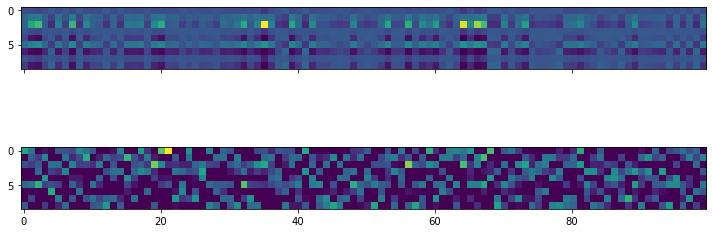

In [9]:
generated = res
fig,ax = plt.subplots(2,1,figsize=(10,5), sharex = True, sharey=True)
ax[0].imshow(generated[:100,:].T)
ax[1].imshow(comp_dset.real_data[:100,:].T)
plt.tight_layout()

In [10]:
_,_,_, mu, logvar = vae(vec_comps_t,y_scaled_t)
z = vae.reparameterize(mu,logvar)

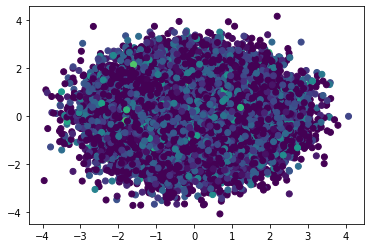

In [11]:
c = vec_comps[:,-2]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed = pca.fit_transform(z.to('cpu').detach().numpy())
plt.scatter(transformed[:,0],transformed[:,1], c=c)

In [13]:
import umap
reducer = umap.UMAP()
transformed_umap = reducer.fit_transform(z.to('cpu').detach().numpy())

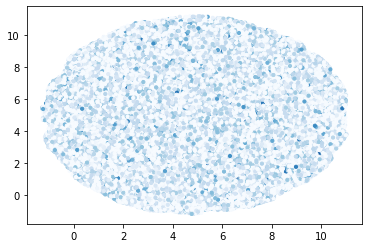

In [39]:
plt.scatter(transformed_umap[:,0],transformed_umap[:,1], c=c.reshape(-1,1), cmap = 'Blues', s=10)

# GAN

In [4]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data
properties = ['uts1200C','price','density']

y = to_train_df.loc[:,properties].values.reshape(-1,len(properties)).astype('float32')
y_scaled = scaler.transform(y)
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
v = kde.fit(y_scaled)

In [5]:
def prop_sampler(n_samples):
    return kde.sample(n_samples).astype('float32')

def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')


def plot(points,dset, title,  thresh=0.01):

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax = ax.flatten()
    ax[0].set_title(title)
    ax[0].violinplot(points, np.arange(points.shape[1]))
    ax[0].set_xticks(np.arange(dset.size))
    ax[0].set_xticklabels(dset.elements)
    s = points.sum(axis=1)
    if np.max(s) - np.min(s) < 0.010:
        ax[1].hist(s, np.linspace(0.990, 1.010, 6))
    else:
        ax[1].hist(s)
    ax[2].hist(points.flatten())
    ne = (points > thresh).sum(axis=1)
    ax[3].hist(ne, np.arange(0, 12), width=0.80)
    plt.show()
    plt.close()


In [6]:
batch_size =1000
minibatch_size = batch_size
prop_dim = y_scaled.shape[1]
latent_dim = 6
gen_in = latent_dim + prop_dim
hidden = gen_in*2
n_hidden = 3
gen_out = comp_dset.size
cuda = check_cuda()

/noether/s0/aqd5773/anaconda3/envs/candidate_generation/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
model_path = 'saved_models'
if os.path.exists(os.path.join(model_path, 'GAN_generator_multi_test.pt')):
    generator = torch.jit.load(os.path.join(model_path, 'GAN_generator_multi_test.pt'), map_location='cpu')
else:
    print('train model first!')

### Correlation with latent dim

In [39]:
el_list

array(['Al', 'C', 'Co', 'Cr', 'Cu', 'Fe', 'Hf', 'Mn', 'Mo', 'Nb', 'Ni',
       'Si', 'Sn', 'Ta', 'Ti', 'V', 'Zr', 'W'], dtype='<U2')

In [9]:
np.random.seed(0)
n_samples  =10000
uniform_noise = np.random.uniform(0,1, size = (n_samples, latent_dim)).astype('float32')
gen_input = torch.from_numpy(uniform_noise)
prop_input = prop_sampler(n_samples)
prop_input =  torch.from_numpy(prop_input)
if cuda:
        generator = generator.cuda()
        gen_input = gen_input.cuda()
        prop_input = prop_input.cuda()

g_fake_data = generator(gen_input,prop_input).to('cpu').detach().numpy()
uts_synthetic = [get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data]

w_ind = np.argwhere(el_list == 'W').item()
w_content = g_fake_data[:,w_ind]




start = uniform_noise[np.argmax(g_fake_data[:,w_ind])]
starting_w = g_fake_data[:,w_ind][np.argmax(g_fake_data[:,w_ind])]
start_prop = prop_input[np.argmax(g_fake_data[:,w_ind])]
start_comp = g_fake_data[np.argmax(g_fake_data[:,w_ind])]

In [18]:
from scipy.stats import pearsonr
for i in range(uniform_noise.shape[1]):
    print(f'Correlation with dim {i+1} : {pearsonr(uniform_noise[:,i], w_content)[0]}')

Correlation with dim 1 : -0.0004652386236245589
Correlation with dim 2 : 0.0015739352181187386
Correlation with dim 3 : -0.003913899864663147
Correlation with dim 4 : 0.0027251477931369214
Correlation with dim 5 : -0.005951264826948886
Correlation with dim 6 : -0.0011905233999064623


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(uniform_noise)
predicted_w = []
for i, (train_idx,test_idx) in enumerate(kf.split(uniform_noise)):
    X_train, y_train = uniform_noise[train_idx], w_content[train_idx]
    X_test, y_test = uniform_noise[test_idx],w_content[test_idx]
    LNRmodel = LinearRegression()
    LNRmodel.fit(X_train,y_train)
    y_pred = LNRmodel.predict(X_test)
    predicted_w.append(pearsonr(y_pred,y_test)[0])
np.mean(predicted_w), np.std(predicted_w)

(0.003668562095783364, 0.023027067688092775)

In [13]:
np.random.seed(0)
LNRmodel = LinearRegression()
LNRmodel.fit(uniform_noise, w_content)
dominant_dir = LNRmodel.coef_

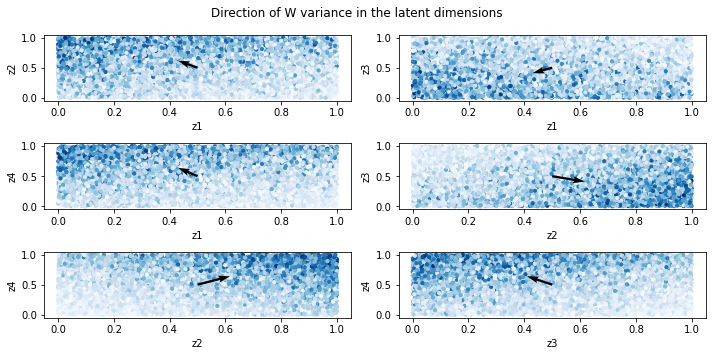

In [14]:
from itertools import combinations
perm = combinations(np.arange(uniform_noise.shape[1]), 2)  
fig,ax = plt.subplots(3,2,figsize = (10,5))
ax = ax.flatten()
for k,i in enumerate(list(perm)):
    a,b = i
    ax[k].scatter(uniform_noise[:,a],uniform_noise[:,b],s = 10, c = w_content[:],cmap = 'Blues')
    ax[k].quiver(0.5,0.5,dominant_dir[a],dominant_dir[b],angles='xy', scale_units='xy', scale=1)
    ax[k].set_xlabel('z{}'.format(a+1))
    ax[k].set_ylabel('z{}'.format(b+1))

plt.suptitle('Direction of W variance in the latent dimensions')
plt.tight_layout()

In [15]:
def prop_sampler_mod(n_samples, fixed = False, val = False):
    if fixed:
        ones = np.ones((n_samples,1))
        if not val:
            return (ones*kde.sample(1)).astype('float32')
        else:
            return (ones*val).astype('float32')
    else:
        return kde.sample(n_samples).astype('float32')

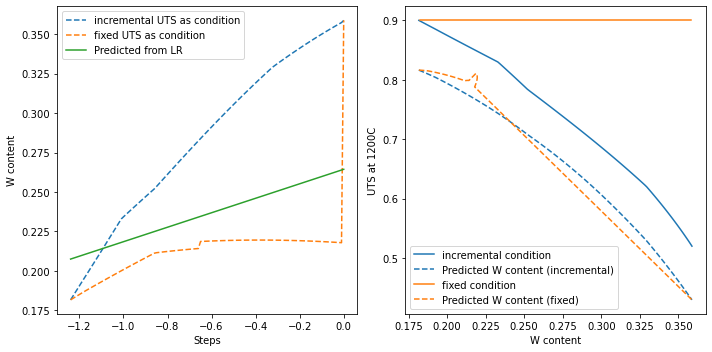

In [21]:
np.random.seed(0)
fixed_uts = uts_scaler.transform(np.array([[0.90]]).reshape(-1,1))
sp = start_prop.to('cpu').detach().numpy()
count = np.arange(fixed_uts,sp,-0.01).astype('float32').reshape(-1,1)
fixed_bin = [False,True]
fig,ax = plt.subplots(1,2, figsize = (10,5))
ax = ax.ravel()
fixed_dict, inc_dict = {},{}
for bin in fixed_bin:
        i = int(bin)
        if bin:
                prop_input = prop_sampler_mod(len(count),fixed = bin, val = fixed_uts)
                label = 'fixed UTS as condition'
        else:
                prop_input = count
                label = 'incremental UTS as condition'
        prop_input[-1] = start_prop.to('cpu').detach().numpy()
        prop_input =  torch.from_numpy(prop_input)
        
        n_points = np.arange(-len(prop_input)+1,1,1).reshape(-1,1)*0.01
        mods = n_points*dominant_dir
        static_noise=np.ones((len(mods),1))*start
        new_latent_dims = static_noise + mods
        new_predicted_w = LNRmodel.predict(new_latent_dims)
        gen_input = torch.from_numpy(new_latent_dims.astype('float32'))
        if cuda:
                generator = generator.cuda()
                gen_input = gen_input.cuda()
                prop_input = prop_input.cuda()
        g_fake_data_fixed = generator(gen_input,prop_input).to('cpu').detach().numpy()
        g_fake_data_fixed[g_fake_data_fixed<0.02] = 0
        g_fake_data_fixed /= g_fake_data_fixed.sum(axis=1).reshape(-1,1)

        gen_w_content = g_fake_data_fixed[:,w_ind]

        g_fake_data_uts = np.array([get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data_fixed]).reshape(-1,1)
        ax[0].plot(n_points,gen_w_content, linestyle='dashed', label = label)

        
        if not bin:
                gen_inc = g_fake_data_fixed[0]
                c = 'tab:blue'
                label = 'incremental'
                ax[1].plot(gen_w_content, uts_scaler.inverse_transform(prop_input.to('cpu').detach().numpy()), color = c, label = '{} condition'.format(label))
        else:
                gen_fix = g_fake_data_fixed[0]
                c = 'tab:orange'
                label = 'fixed'
                ax[1].axhline(y = 0.9, xmin = 0.05, xmax = 0.95, color = c, label = '{} condition'.format(label))
        ax[1].plot(gen_w_content, g_fake_data_uts, color = c, linestyle = 'dashed', label = 'Predicted W content ({})'.format(label))

        if bin:
                fixed_dict = {
                        'predicted_w' : new_predicted_w.tolist(),
                        'actual_w':gen_w_content.tolist(),
                        'g_fake_data':g_fake_data_fixed.tolist(),
                        'g_fake_data_uts':g_fake_data_uts.tolist(),
                        'y' : 0.9,
                        'x':n_points.tolist()
                }
        elif not bin:
                inc_dict = {
                        'predicted_w' : new_predicted_w.tolist(),
                        'actual_w':gen_w_content.tolist(),
                        'g_fake_data':g_fake_data_fixed.tolist(),
                        'g_fake_data_uts':g_fake_data_uts.tolist(),
                        'y':uts_scaler.inverse_transform(prop_input.to('cpu').detach().numpy()).tolist(),
                        'x':n_points.tolist()
                }

ax[0].plot(n_points,new_predicted_w, label = 'Predicted from LR')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('W content')
ax[1].set_xlabel('W content')
ax[1].set_ylabel('UTS at 1200C')
ax[0].legend()
ax[1].legend()

plt.tight_layout()

In [139]:
to_consider = sorted(['Nb','Mo','Zr','Ti','V','W','Hf','Cr','Ta'])
results_dict = {
    'inverse':{
        'constants':{
        'uniform_noise':uniform_noise.tolist(),
        'w_content':w_content.tolist(),
        'dominant_dir':dominant_dir.tolist(),
        'to_consider':to_consider
        },
    'fixed': fixed_dict,
    'inc' : inc_dict
    }

}
with open('results.json','w') as fid:
    json.dump(results_dict,fid)

In [17]:
import pymatgen.core as mg
def decode(vec, elem_list, thresh=0.02):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    #comp = ''
    #for i, x in enumerate(vec):
    #    if x >= thresh:
    #        comp += elem_list[i] + '{:.2f} '.format(x)
    return vec #mg.Composition(comp)

In [18]:
test  = decode(g_fake_data_fixed[-1],el_list)
test2 = decode(g_fake_data_fixed[0],el_list)
np.sum(list(test))

1.0

In [23]:
def get_comp(vec, elem_list, thresh=0.02):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    comp = ''
    for i, x in enumerate(vec):
        if x > 0:
            comp += elem_list[i] + '{:.2f} '.format(x)
    return mg.Composition(comp)

get_comp(gen_inc,el_list), get_comp(gen_fix,el_list)

(Comp: Hf0.25 Zr0.05 Ti0.28 Nb0.03 Cr0.07 Mo0.14 W0.18,
 Comp: Hf0.25 Zr0.05 Ti0.28 Nb0.03 Cr0.07 Mo0.14 W0.18)

In [144]:
json_dict = {
    'start_comp' : test.tolist(),
    'start_uts' : g_fake_data_uts[-1].item(),
    'start_w_content' : test[w_ind].item(),
    'end_w_content': test2[w_ind].item()
}
with open('misc/starting_comp.json','w') as fid:
    json.dump(json_dict,fid)